# Identify Fraud from Enron Email
## Project for Introduction to Machine Learning 

In [1]:
import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

### Task 1: Select what features you'll use. 

In [2]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [3]:
# total number of data points (i.e.,numer of people)
print "Number of people: ", len(data_dict)  

# number of features (before feature selection)
print "Number of features:", len(data_dict[data_dict.keys()[0]]) 

# number of POI/non-POI

count_POI = 0
count_nonPOI = 0
count_NaN = 0
for key in data_dict:
    if data_dict[key]["poi"]== True:
        count_POI = count_POI + 1
    elif data_dict[key]["poi"]== False:
        count_nonPOI = count_nonPOI + 1
    else:
        count_NaN = count_NaN + 1
        
print "Number of POIs:", count_POI
print "Number of non-POIs:", count_nonPOI 

if count_NaN > 0:
    print "Number of neither POI nor non-POIs:", count_NaN

Number of people:  146
Number of features: 21
Number of POIs: 18
Number of non-POIs: 128


This dataset is pretty small (146 data points). The numbers of POIs and non-POIs are unbalanced (18 vs.128); there are much more non-POIs. Thus, a validation method should be carefully decided later. 

In [4]:
# check available features 
feature_list_all = data_dict[data_dict.keys()[0]].keys()
print feature_list_all

['salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'email_address', 'from_poi_to_this_person']


In [5]:
# check missing values for each feature
NaN_Count =dict.fromkeys(feature_list_all,0)

for person in data_dict:
    for key in feature_list_all:
        if data_dict[person][key] == 'NaN':
            NaN_Count[key] += 1

print "_____NaN_Count:_____"
print NaN_Count   

# features with over 70% of missing values
print "_____Features with over 70% of missing values:_____"
People_count = len(data_dict)
for key in NaN_Count:
    if NaN_Count[key] > People_count*.70:
        print key, NaN_Count[key], "(%0.1f" % (NaN_Count[key]*100.0/len(data_dict)),"% missing)"

_____NaN_Count:_____
{'salary': 51, 'to_messages': 60, 'deferral_payments': 107, 'total_payments': 21, 'loan_advances': 142, 'bonus': 64, 'email_address': 35, 'restricted_stock_deferred': 128, 'total_stock_value': 20, 'shared_receipt_with_poi': 60, 'long_term_incentive': 80, 'exercised_stock_options': 44, 'from_messages': 60, 'other': 53, 'from_poi_to_this_person': 60, 'from_this_person_to_poi': 60, 'poi': 0, 'deferred_income': 97, 'expenses': 51, 'restricted_stock': 36, 'director_fees': 129}
_____Features with over 70% of missing values:_____
deferral_payments 107 (73.3 % missing)
loan_advances 142 (97.3 % missing)
restricted_stock_deferred 128 (87.7 % missing)
director_fees 129 (88.4 % missing)


The above shows the number of missing values for each feature and the list of features with over 70% of missing values. For example, most of values for loan_advances are missing; only 4 values are not missing. However, I will check whether any of these features still might be good features for identifying POIs. 

In [6]:
# check POI counts among non missing values of features with over 70% missing values
Feature_with_over100NaNs =['deferral_payments','loan_advances','restricted_stock_deferred','director_fees']
POI_Count_among_NonNaN =dict.fromkeys(Feature_with_over100NaNs,0)
for person in data_dict:
    for key in Feature_with_over100NaNs:
        if data_dict[person][key] != 'NaN' and data_dict[person]['poi']==1:
            POI_Count_among_NonNaN[key] += 1
print POI_Count_among_NonNaN

{'loan_advances': 1, 'restricted_stock_deferred': 0, 'deferral_payments': 5, 'director_fees': 0}


The above numbers represent POI counts among people with available values for those features with over 70% missing values. There is only one POI among the people with available loan_advances values. Recall that there were only 4 available values for loan_advances. Since 1 out of 4 is a pretty big ratio, I will keep this feature for now. No one is POI among the people with available values for restricted_stock_deferred and director_fees. I will remove these two features since these cannot help identifying POIs. This makes me wonder whether there are any other features like these, i.e., features that have no POI if the features have available values. I checked them below and found no more such features.

In [7]:
# check POI counts among non missing values of features 
POI_Count_all_features =dict.fromkeys(feature_list_all,0)
for person in data_dict:
    for key in feature_list_all:
        if data_dict[person][key] != 'NaN' and data_dict[person]['poi']==1:
            POI_Count_all_features[key] += 1
print POI_Count_all_features

{'salary': 17, 'to_messages': 14, 'deferral_payments': 5, 'total_payments': 18, 'loan_advances': 1, 'bonus': 16, 'email_address': 18, 'restricted_stock_deferred': 0, 'total_stock_value': 18, 'shared_receipt_with_poi': 14, 'long_term_incentive': 12, 'exercised_stock_options': 12, 'from_messages': 14, 'other': 18, 'from_poi_to_this_person': 14, 'from_this_person_to_poi': 14, 'poi': 18, 'deferred_income': 11, 'expenses': 18, 'restricted_stock': 17, 'director_fees': 0}


Thus, for now I will only remove those two features and email_address, which is the only feature with a text string. I will try to remove more features after finding a good classifier algorithm.

In [8]:
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','salary', 'to_messages', 'deferral_payments', 'total_payments', 
                 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 
                 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 
                 'from_this_person_to_poi', 'deferred_income', 'long_term_incentive', 
                 'from_poi_to_this_person'] 
print len(features_list)

18


### Task 2: Remove outliers

In [9]:
### Store to my_dataset for easy export below.
my_dataset = data_dict

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list , sort_keys = False, remove_all_zeroes=False) # I changed the last 2 arguments
labels, features = targetFeatureSplit(data)

It seems one data point with some key (person) was removed in featureFormat() if the default value True for argument remove_all_zeroes is used. However, I used 'remove_all_zeroes=False' and also 'sort_keys=False' to keep track of names of people.  

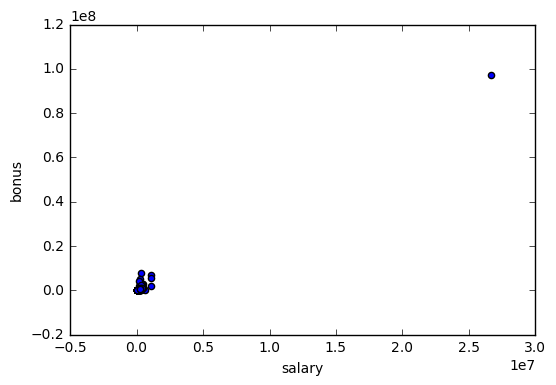

max salary and name: 26704229.0 TOTAL
max bonus and name: 97343619.0 TOTAL


In [10]:
import matplotlib.pyplot as plt

max_salary = 0
max_bonus = 0 
for ii, point in enumerate(data):
    salary = point[features_list.index('salary')]
    if salary > max_salary:
        max_salary = salary
        max_salary_index = ii
    bonus = point[features_list.index('bonus')]
    if bonus > max_bonus:
        max_bonus = bonus
        max_bonus_index = ii
    plt.scatter(salary, bonus)

plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

print "max salary and name:",  max_salary, data_dict.keys()[max_salary_index] 
print "max bonus and name:", max_bonus, data_dict.keys()[max_bonus_index] 

The scatter plot for salary vs. bonus shows a very extreme outlier. I found the outlier is from the wrong key 'TOTAL', so I will remove the key and its values and make a scatter plot again.

In [11]:
# Count missing values for each key (person) 
NaN_Count_Person =dict.fromkeys(data_dict.keys(),0) 

for person in data_dict:
    for key in feature_list_all:
        if data_dict[person][key] == 'NaN':
            NaN_Count_Person[person] += 1

#print "_____Number of NaNs for each person:_____"
#print NaN_Count_Person   

In [12]:
# Find people with over 80% missing features (except for 'poi')
print "_____Number of NaNs for people with over 80% missing features:_____"

for person in data_dict:
    if NaN_Count_Person[person] > 16:
        print person, NaN_Count_Person[person]

_____Number of NaNs for people with over 80% missing features:_____
WODRASKA JOHN 17
WHALEY DAVID A 18
CLINE KENNETH W 17
WAKEHAM JOHN 17
WROBEL BRUCE 18
SCRIMSHAW MATTHEW 17
GILLIS JOHN 17
LOCKHART EUGENE E 20
THE TRAVEL AGENCY IN THE PARK 18
SAVAGE FRANK 17
GRAMM WENDY L 18


'LOCKHART EUGENE E' has no available feature values other than 'poi'. 'THE TRAVEL AGENCY IN THE PARK' is not a name of a person. I can remove these two keys and their values from the dictionary data_dict, but I will keep these since they might also help identifying POIs (Later, I found they actually help). 

In [13]:
del data_dict['TOTAL']  #delete the wrong data 
# or data_dict.pop("TOTAL", 0)

# update data after deleting 'TOTAL'
my_dataset = data_dict
data = featureFormat(my_dataset, features_list, sort_keys = False, remove_all_zeroes=False)
labels, features = targetFeatureSplit(data)

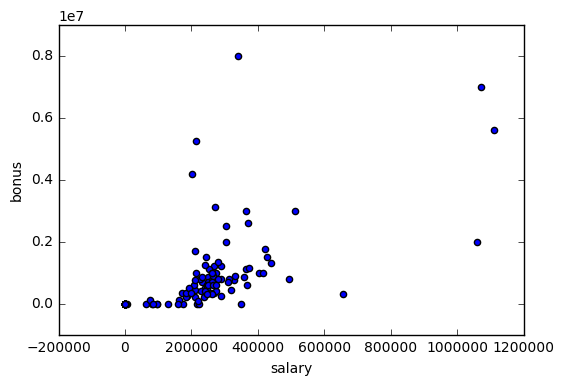

max salary and name: 1111258.0 SKILLING JEFFREY K
max bonus and name: 8000000.0 LAVORATO JOHN J


In [14]:
max_salary = 0
max_bonus = 0 
for ii, point in enumerate(data):
    salary = point[features_list.index('salary')]
    if salary > max_salary:
        max_salary = salary
        max_salary_index = ii
    bonus = point[features_list.index('bonus')]
    if bonus > max_bonus:
        max_bonus = bonus
        max_bonus_index = ii
    plt.scatter( salary, bonus )

plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

print "max salary and name:",  max_salary, data_dict.keys()[max_salary_index] 
print "max bonus and name:", max_bonus, data_dict.keys()[max_bonus_index] 

Now the scatter plot looks ordinary. There are still some points with extreme salary and bonus amounts, but they are plausible.
I will briefly check if there are any other outliers using histograms.

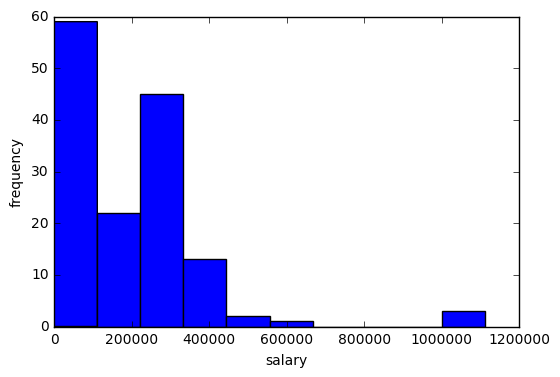

max salary : SKILLING JEFFREY K


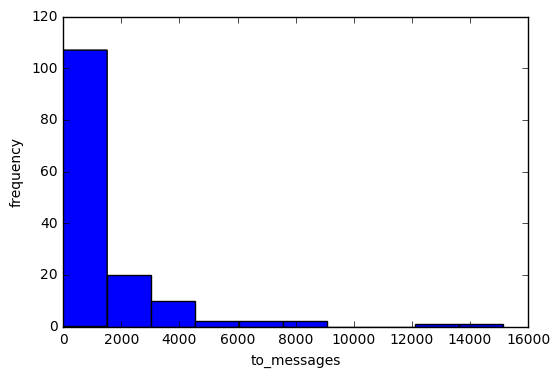

max to_messages : SHAPIRO RICHARD S


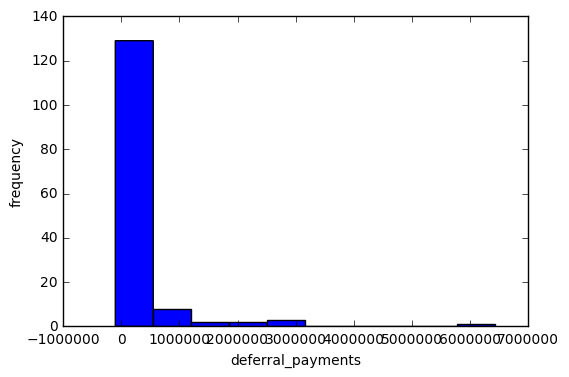

max deferral_payments : FREVERT MARK A


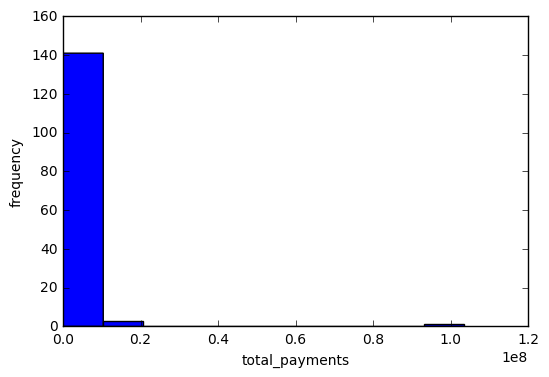

max total_payments : LAY KENNETH L


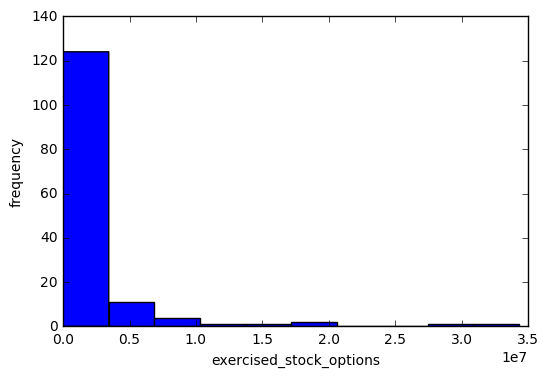

max exercised_stock_options : LAY KENNETH L


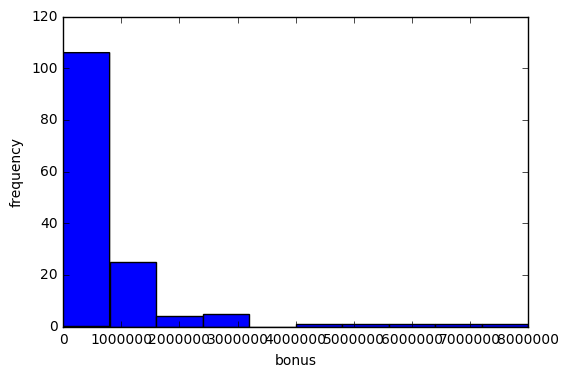

max bonus : LAVORATO JOHN J


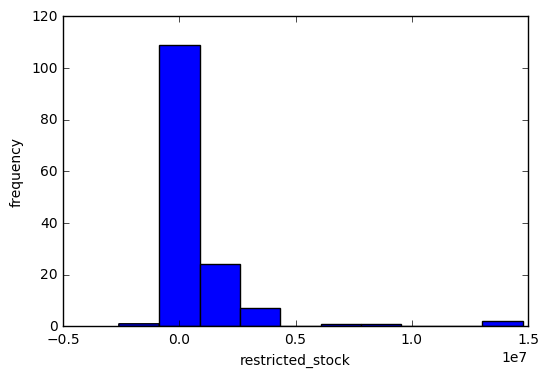

max restricted_stock : LAY KENNETH L


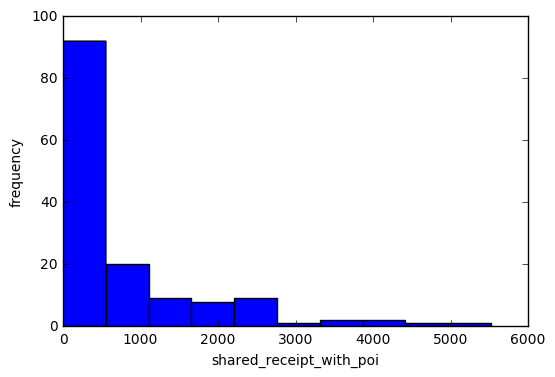

max shared_receipt_with_poi : BELDEN TIMOTHY N


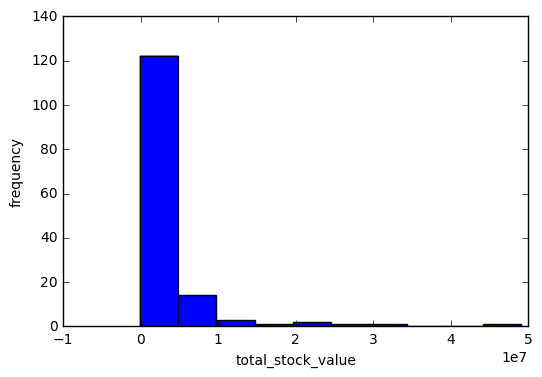

max total_stock_value : LAY KENNETH L


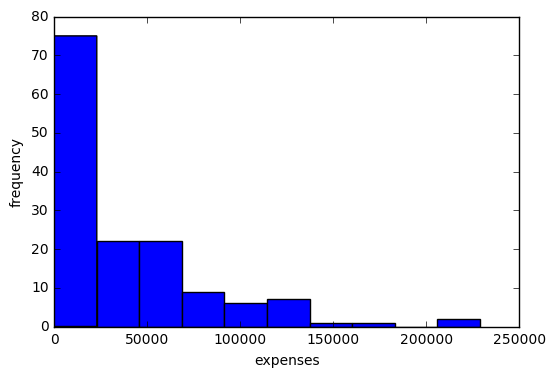

max expenses : MCCLELLAN GEORGE


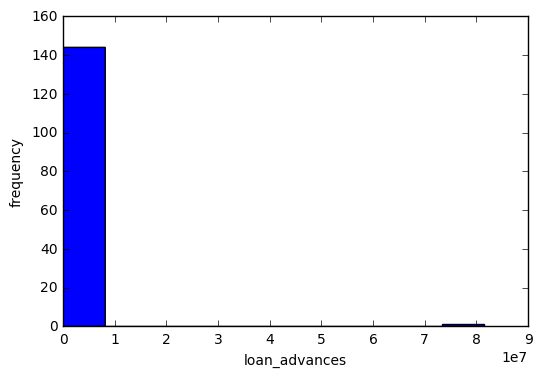

max loan_advances : LAY KENNETH L


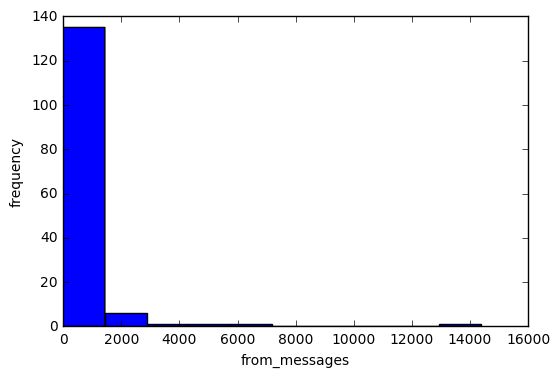

max from_messages : KAMINSKI WINCENTY J


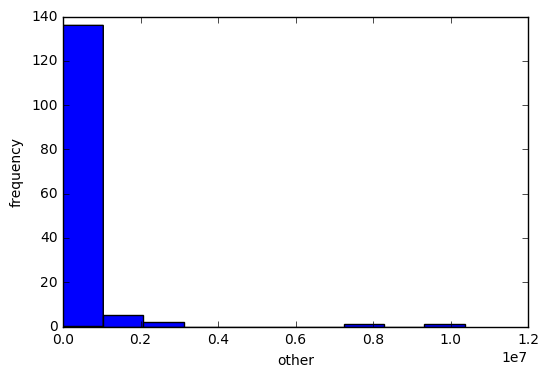

max other : LAY KENNETH L


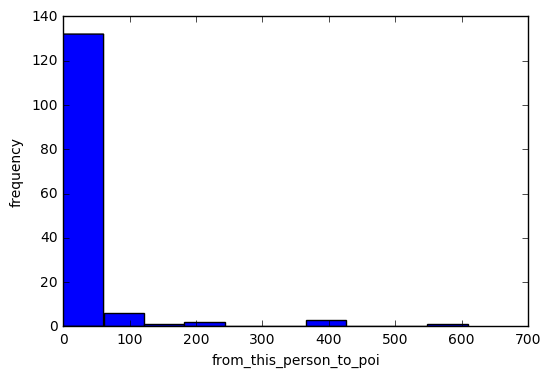

max from_this_person_to_poi : DELAINEY DAVID W


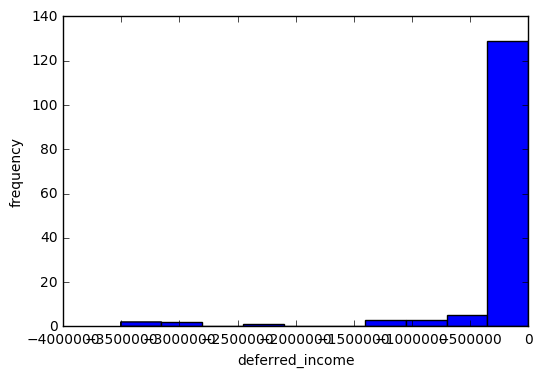

min deferred_income : RICE KENNETH D


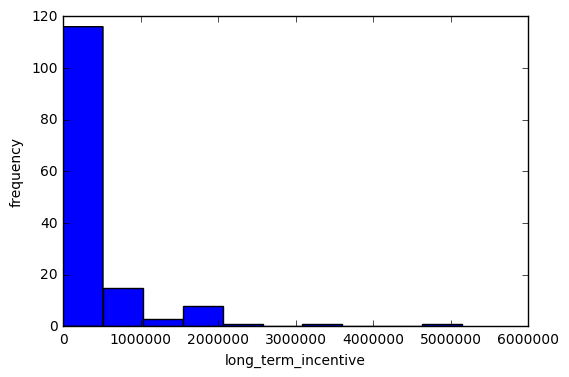

max long_term_incentive : MARTIN AMANDA K


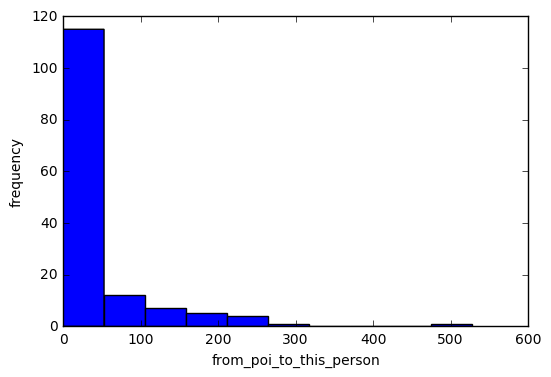

max from_poi_to_this_person : LAVORATO JOHN J


In [15]:
for feature in features_list[1:]: #[1:] to skip 'poi'
    feature_values =[]
    for point in data:
        feature_values.append(point[features_list.index(feature)])
    plt.hist(feature_values)
    plt.xlabel(feature)
    plt.ylabel("frequency")
    plt.show()
    if feature != 'deferred_income': 
        print "max", feature, ":", data_dict.keys()[feature_values.index(max(feature_values))]
    else:
        print "min", feature, ":", data_dict.keys()[feature_values.index(min(feature_values))]
        

I could not find any more suspicious outliers since outlier names and their values were plausible. For example, 'LAY KENNETH L', the former CEO and chairman of Enron Corporation, was the most frequent outlier for financial features.

### Task 3: Create new feature(s)

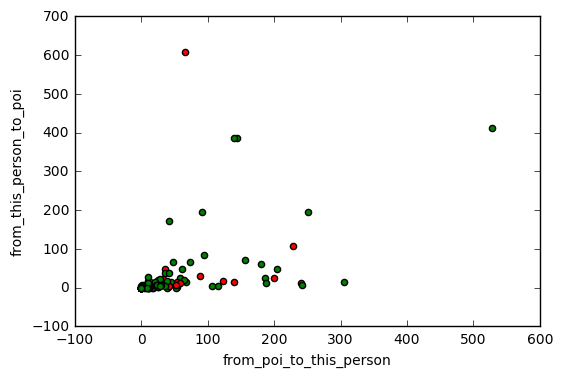

In [16]:
# Check the relationship among from_poi_to_this_person,from_this_person_to_poi and POIs
for point in data:
    from_poi_to_this_person = point[features_list.index('from_poi_to_this_person')]
    from_this_person_to_poi = point[features_list.index('from_this_person_to_poi')]
    poi = point[features_list.index('poi')]
    if poi ==1:
        plt.scatter( from_poi_to_this_person, from_this_person_to_poi, c='red')
    else:
        plt.scatter( from_poi_to_this_person, from_this_person_to_poi, c='green')    
plt.xlabel("from_poi_to_this_person")
plt.ylabel("from_this_person_to_poi")
plt.show()

This scatter plot shows the two features from_poi_to_this_person and from_this_person_to_poi do not seem to help identifying POIs (red dots). Thus, I will create two new features, the proportion of messages to POIs from this person among all messages from this person and the proportion of messages from POIs to this person among all messages to this person. The new features are more likely to show the real impact of messages from POIs and to POIs on identifying POIs.

In [17]:
### modified from the quiz in the feature selection lesson

def computeFraction( poi_messages, all_messages ):
    if (all_messages == "NaN") or (poi_messages =="NaN"):
        fraction = 0.
    else:
        fraction = poi_messages*1.0/all_messages
        
    return fraction 

for name in data_dict:

    data_point = data_dict[name]

    from_poi_to_this_person = data_point["from_poi_to_this_person"]
    to_messages = data_point["to_messages"]
    fraction_from_poi = computeFraction( from_poi_to_this_person, to_messages )
    #print fraction_from_poi
    data_point["fraction_from_poi"] = fraction_from_poi


    from_this_person_to_poi = data_point["from_this_person_to_poi"]
    from_messages = data_point["from_messages"]
    fraction_to_poi = computeFraction( from_this_person_to_poi, from_messages )
    #print fraction_to_poi
    data_point["fraction_to_poi"] = fraction_to_poi
    
print "New Number of features in data_dict:", len(data_dict[data_dict.keys()[0]]) 

New Number of features in data_dict: 23


In [18]:
# update data after adding the two new features
features_list = ['poi','salary', 'to_messages', 'deferral_payments', 'total_payments', 
                 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 
                 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 
                 'from_this_person_to_poi', 'deferred_income', 'long_term_incentive', 
                 'from_poi_to_this_person', 'fraction_from_poi','fraction_to_poi']
print features_list
print "New Number of features in features_list:", len(features_list) 
my_dataset = data_dict

data = featureFormat(my_dataset, features_list , sort_keys = False, remove_all_zeroes=False) # I changed the last 2 arguments
labels, features = targetFeatureSplit(data)

['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'deferred_income', 'long_term_incentive', 'from_poi_to_this_person', 'fraction_from_poi', 'fraction_to_poi']
New Number of features in features_list: 20


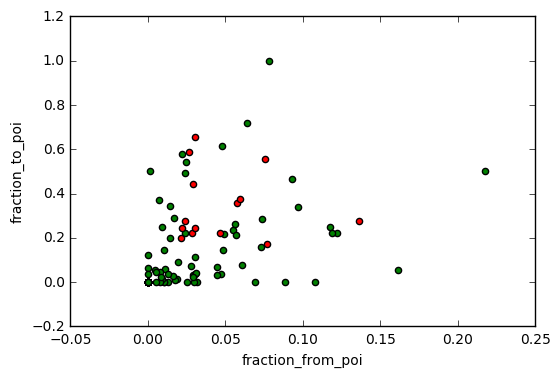

In [19]:
# Check the relationship between from_poi_to_this_person and from_this_person_to_poi
for point in data:
    fraction_from_poi = point[features_list.index('fraction_from_poi')]
    fraction_to_poi = point[features_list.index('fraction_to_poi')]
    poi = point[features_list.index('poi')]
    if poi ==1:
        plt.scatter( fraction_from_poi, fraction_to_poi, c='red')
    else:
        plt.scatter( fraction_from_poi, fraction_to_poi, c='green')
plt.xlabel("fraction_from_poi")
plt.ylabel("fraction_to_poi")
plt.show()

The new scatter plot shows that POIs (red dots) are those who have a higher ratio of POI messages to all messages. Thus, these new features, fraction_from_poi and fraction_to_poi, are likely to be better predictors than the two old features, from_poi_to_this_person and from_this_person_to_poi.

### Task 4: Try a varity of classifiers

In [20]:
from tester import test_classifier
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42) #unused since test_classifier() was used

##### Gaussian NB

In [21]:
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# GaussianNB

from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

### the original fit and predict steps, but replaced with test_classifier()
#clf = clf.fit(features_train,labels_train)
#pred = clf.predict(features_test)
#from sklearn.metrics import accuracy_score
#print "Accuracy: ", accuracy_score(pred, labels_test)
#from sklearn.metrics import precision_score, recall_score
#print "precision:", precision_score(labels_test, pred) 
#print "recall:", recall_score(labels_test, pred)  

test_classifier(clf, my_dataset, features_list, folds = 1000)

GaussianNB()
	Accuracy: 0.80860	Precision: 0.27424	Recall: 0.26450	F1: 0.26928	F2: 0.26639
	Total predictions: 15000	True positives:  529	False positives: 1400	False negatives: 1471	True negatives: 11600



In [22]:
# GaussianNB with PCA

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
estimators = [('reduce_dim', PCA(n_components=2)), ('clf', GaussianNB())]
clf = Pipeline(estimators)
test_classifier(clf, my_dataset, features_list, folds = 1000)

Pipeline(steps=[('reduce_dim', PCA(copy=True, n_components=2, whiten=False)), ('clf', GaussianNB())])
	Accuracy: 0.87433	Precision: 0.55632	Recall: 0.28400	F1: 0.37603	F2: 0.31482
	Total predictions: 15000	True positives:  568	False positives:  453	False negatives: 1432	True negatives: 12547



Using PCA is much better and n_components=2 seems to be the best parameter for PCA. Recall is still a little less than .3.

##### SVM

In [23]:
# feature scaling
# Since we are going to use SVM, we need to scale our features.
#from sklearn.preprocessing import MinMaxScaler
#clf = MinMaxScaler()
#features_scaled = clf.fit_transform(features)
# Separating training and testing data with scaled features
#from sklearn.cross_validation import train_test_split
#features_train, features_test, labels_train, labels_test = \
#    train_test_split(features_scaled, labels, test_size=0.3, random_state=42)  #features are scaled !!!

In [24]:
# SVM with 'rbf' kernel (default)

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

estimators = [('scale', MinMaxScaler()), ('clf', SVC(kernel ='rbf', C=10))]
clf = Pipeline(estimators)
test_classifier(clf, my_dataset, features_list, folds = 1000)

Pipeline(steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
	Accuracy: 0.86693	Precision: 0.53030	Recall: 0.01750	F1: 0.03388	F2: 0.02170
	Total predictions: 15000	True positives:   35	False positives:   31	False negatives: 1965	True negatives: 12969



In [25]:
# SVM with 'rbf' kernel and class_weight='balanced'

estimators = [('scale', MinMaxScaler()), ('clf', SVC(kernel ='rbf', C=10, class_weight='balanced'))]
clf = Pipeline(estimators)
test_classifier(clf, my_dataset, features_list, folds = 1000)

Pipeline(steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
	Accuracy: 0.71293	Precision: 0.22704	Recall: 0.47950	F1: 0.30816	F2: 0.39226
	Total predictions: 15000	True positives:  959	False positives: 3265	False negatives: 1041	True negatives: 9735



In [26]:
# SVM with 'linear' kernel

estimators = [('scale', MinMaxScaler()), ('clf', SVC(kernel ='linear', C=10))]
clf = Pipeline(estimators)
test_classifier(clf, my_dataset, features_list, folds = 1000)

Pipeline(steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
	Accuracy: 0.86333	Precision: 0.44898	Recall: 0.11000	F1: 0.17671	F2: 0.12956
	Total predictions: 15000	True positives:  220	False positives:  270	False negatives: 1780	True negatives: 12730



In [27]:
# SVM with 'linear' kernel and class_weight = 'balanced'

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

estimators = [('scale', MinMaxScaler()), ('clf', SVC(kernel ='linear', C=10, class_weight = 'balanced'))]
clf = Pipeline(estimators)
test_classifier(clf, my_dataset, features_list, folds = 1000)

Pipeline(steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
	Accuracy: 0.75300	Precision: 0.26431	Recall: 0.47800	F1: 0.34040	F2: 0.41147
	Total predictions: 15000	True positives:  956	False positives: 2661	False negatives: 1044	True negatives: 10339



In [28]:
# SVM with 'linear' kernel, class_weight='balanced' and  PCA 

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

estimators = [('scale', MinMaxScaler()), ('reduce_dim', PCA(n_components=10)), 
              ('clf', SVC(kernel ='linear', C=100, class_weight='balanced'))]
clf = Pipeline(estimators)
test_classifier(clf, my_dataset, features_list, folds = 1000)

Pipeline(steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('reduce_dim', PCA(copy=True, n_components=10, whiten=False)), ('clf', SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
	Accuracy: 0.72673	Precision: 0.24533	Recall: 0.50550	F1: 0.33034	F2: 0.41704
	Total predictions: 15000	True positives: 1011	False positives: 3110	False negatives:  989	True negatives: 9890



SVM cannot make good scores for both Precision and Recall at the same time. If class_weight='balanced' is used, Recall is good, but Precision is lower than .3. If the default setting class_weight=None is used, Precision is good, but Recall is far below .3. I also tried several values for parameter C, but both Precision and Recall cannot exceed 0.3 at the same time.

##### Decision tree

In [29]:
# Decision tree
from sklearn import tree
clf = tree.DecisionTreeClassifier()

test_classifier(clf, my_dataset, features_list, folds = 1000)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.82007	Precision: 0.31730	Recall: 0.30350	F1: 0.31025	F2: 0.30616
	Total predictions: 15000	True positives:  607	False positives: 1306	False negatives: 1393	True negatives: 11694



Both precision and recall are over .3 with the default parameters (e.g. min_samples_split=2). I will check if I can improve this even more with PCA now, but I will tune parameters in the next section.

In [30]:
# Decision tree with PCA

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn import tree
estimators = [('reduce_dim', PCA(n_components=4)), ('clf', tree.DecisionTreeClassifier())]
clf = Pipeline(estimators)
test_classifier(clf, my_dataset, features_list, folds = 1000)

Pipeline(steps=[('reduce_dim', PCA(copy=True, n_components=4, whiten=False)), ('clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
	Accuracy: 0.81613	Precision: 0.31883	Recall: 0.33350	F1: 0.32600	F2: 0.33046
	Total predictions: 15000	True positives:  667	False positives: 1425	False negatives: 1333	True negatives: 11575



Using PCA with n_components=4 improves precision and recall sometimes (the numbers vary). I will check if I can find the better number of components when tuning parameters in the next section.

In [31]:
# feature importance using decision tree

clf = tree.DecisionTreeClassifier()
test_classifier(clf, my_dataset, features_list, folds = 1000)
#clf.fit(features_train, labels_train)
feature_importance =  clf.feature_importances_

important_features = [[features_list[index+1], round(num,2)] for index, num in enumerate(feature_importance)]
print "All features and their importance: \n", important_features, " \n"

print "Important features and their importance:"
count = 0
for index, num in enumerate(feature_importance):
    if num >  0.0:
        count += 1
        print features_list[index+1], round(num,2)
print ""
print "In total, %d features had importance over zero" %(count)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.81813	Precision: 0.31198	Recall: 0.30200	F1: 0.30691	F2: 0.30395
	Total predictions: 15000	True positives:  604	False positives: 1332	False negatives: 1396	True negatives: 11668

All features and their importance: 
[['salary', 0.0], ['to_messages', 0.0], ['deferral_payments', 0.0], ['total_payments', 0.12], ['exercised_stock_options', 0.33], ['bonus', 0.06], ['restricted_stock', 0.08], ['shared_receipt_with_poi', 0.13], ['total_stock_value', 0.07], ['expenses', 0.0], ['loan_advances', 0.0], ['from_messages', 0.0], ['other', 0.07], ['from_this_person_to_poi', 0.0], ['deferred_income', 0.0], ['long_term_incentive', 0.0], ['from_poi_to_this_person', 0.02], ['fraction_from_poi', 0.0], ['fraction_to_poi', 0.1

I found 'fraction_to_poi' indeed has higher feature importance than 'from_this_person_to_poi'. However, the original feature 'from_poi_to_this_person' was actually more important than the new feature 'fraction_from_poi. Thsese findings were consistently true although feature importances and features with nonzero importance varied each run. Since the important features and their importances vary for each run, I am not going to use this result for further analysis.

### Task 5: Tune your classifier to achieve better than .3 precision and recall 

In [32]:
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

I will tune parameters for a decision tree with PCA since, in the previous section, a decision tree was found to be the only algorithm that can have good scores over .30 for both Precision and Recall at the same time.

In [33]:
# Decision tree with PCA using gridSearch
#from sklearn.pipeline import Pipeline
#from sklearn import tree
#from sklearn.decomposition import PCA
#from sklearn.grid_search import GridSearchCV
#
#estimators = [('reduce_dim', PCA()), ('clf', tree.DecisionTreeClassifier())]
#pipe = Pipeline(estimators)
#params = dict(reduce_dim__n_components=[2,4,5,10,15], clf__min_samples_split =[2,10,20,40,50])
#clf = GridSearchCV(pipe, param_grid=params)
#
#test_classifier(clf, my_dataset, features_list, folds = 1000)
#
#print "Best parameters", clf.best_params_

I realized that GridSearch does not focus on maximazing Precision and Recall only. The best parameters it found did not give both Precision and Recall highter than .30. Thus, I will try to tune the parameters manually without GridSearch.

In [34]:
# Decision tree with PCA and min_samples_split=2

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn import tree
estimators = [('reduce_dim', PCA(n_components=4)), ('clf', tree.DecisionTreeClassifier(min_samples_split=2))]
clf = Pipeline(estimators)
test_classifier(clf, my_dataset, features_list, folds = 1000)

Pipeline(steps=[('reduce_dim', PCA(copy=True, n_components=4, whiten=False)), ('clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
	Accuracy: 0.81827	Precision: 0.32293	Recall: 0.33100	F1: 0.32691	F2: 0.32935
	Total predictions: 15000	True positives:  662	False positives: 1388	False negatives: 1338	True negatives: 11612



In [35]:
# Decision tree with PCA and min_samples_split=40

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn import tree
estimators = [('reduce_dim', PCA(n_components=4)), ('clf', tree.DecisionTreeClassifier(min_samples_split=40))]
clf = Pipeline(estimators)
test_classifier(clf, my_dataset, features_list, folds = 1000)

Pipeline(steps=[('reduce_dim', PCA(copy=True, n_components=4, whiten=False)), ('clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=40, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
	Accuracy: 0.85880	Precision: 0.42874	Recall: 0.17750	F1: 0.25106	F2: 0.20106
	Total predictions: 15000	True positives:  355	False positives:  473	False negatives: 1645	True negatives: 12527



In [36]:
# Decision tree with PCA and min_samples_split=10

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn import tree
estimators = [('reduce_dim', PCA(n_components=4)), ('clf', tree.DecisionTreeClassifier(min_samples_split=10))]
clf = Pipeline(estimators)
test_classifier(clf, my_dataset, features_list, folds = 1000)

Pipeline(steps=[('reduce_dim', PCA(copy=True, n_components=4, whiten=False)), ('clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
	Accuracy: 0.83893	Precision: 0.38073	Recall: 0.33200	F1: 0.35470	F2: 0.34072
	Total predictions: 15000	True positives:  664	False positives: 1080	False negatives: 1336	True negatives: 11920



In [42]:
# Decision tree with SelectKBest

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import tree
estimators = [('reduce_dim', SelectKBest(f_classif, k=14)), ('clf', tree.DecisionTreeClassifier(min_samples_split=2))]
clf = Pipeline(estimators)

test_classifier(clf, my_dataset, features_list, folds = 1000)

#features_selected_bool = clf.named_steps['reduce_dim'].get_support()
#features_selected =[features_list[index+1] for index, bool in enumerate(features_selected_bool) if bool] 
#print "Features_selected by SelectKBest: \n", features_selected

features_selected_index = clf.named_steps['reduce_dim'].get_support(indices = True)
features_importances =  clf.named_steps['clf'].feature_importances_
features_selected_importances =[[features_list[index+1],round(features_importances[ii],2)] for ii, index in enumerate(features_selected_index)] 

print "Selected features and their importances by SelectKBest: \n", features_selected_importances

Pipeline(steps=[('reduce_dim', SelectKBest(k=14, score_func=<function f_classif at 0x000000000B0AC518>)), ('clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
	Accuracy: 0.82340	Precision: 0.32930	Recall: 0.31300	F1: 0.32094	F2: 0.31613
	Total predictions: 15000	True positives:  626	False positives: 1275	False negatives: 1374	True negatives: 11725

Selected features and their importances by SelectKBest: 
[['salary', 0.0], ['total_payments', 0.05], ['exercised_stock_options', 0.24], ['bonus', 0.0], ['restricted_stock', 0.03], ['shared_receipt_with_poi', 0.25], ['total_stock_value', 0.11], ['expenses', 0.0], ['loan_advances', 0.0], ['other', 0.0], ['deferred_income', 0.05], ['long_term_incentive', 0.12], ['from_poi_to_this_person', 0.02], ['fraction_to_poi', 0

In [43]:
features_selected = features = [item[0] for item in features_selected_importances]
print features_selected

['salary', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'total_stock_value', 'expenses', 'loan_advances', 'other', 'deferred_income', 'long_term_incentive', 'from_poi_to_this_person', 'fraction_to_poi']


The feature scores also varied, but every run gave the same 14 selected features. I chose k=14 for SelectKBest because the parameter gave the best precision and recall scores over .30 from a decision tree.

In [44]:
# Decision tree with PCA using features_selected

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn import tree
estimators = [('reduce_dim', PCA(n_components=13)), ('clf', tree.DecisionTreeClassifier(min_samples_split=10))]
clf = Pipeline(estimators)
test_classifier(clf, my_dataset, ['poi']+features_selected, folds = 1000) #note:  features_list was replaced !!!

Pipeline(steps=[('reduce_dim', PCA(copy=True, n_components=13, whiten=False)), ('clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
	Accuracy: 0.83727	Precision: 0.37291	Recall: 0.32350	F1: 0.34645	F2: 0.33231
	Total predictions: 15000	True positives:  647	False positives: 1088	False negatives: 1353	True negatives: 11912



I Tuned parameters for PCA. Both precision and recall are good, but stil slightly worse than those of a decision tree + PCA with all 19 features. The results suggest SelectBest does not outperform PCA and PCA with all 19 features was better than PCA with the 14 features.

In [45]:
# Decision tree with PCA

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn import tree
estimators = [('reduce_dim', PCA(n_components=4)), ('clf', tree.DecisionTreeClassifier(min_samples_split=10))]
clf = Pipeline(estimators)
test_classifier(clf, my_dataset, features_list, folds = 1000)

Pipeline(steps=[('reduce_dim', PCA(copy=True, n_components=4, whiten=False)), ('clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
	Accuracy: 0.83993	Precision: 0.38404	Recall: 0.33200	F1: 0.35613	F2: 0.34125
	Total predictions: 15000	True positives:  664	False positives: 1065	False negatives: 1336	True negatives: 11935



This is so far the best method that gives good scors for both Precision and Recall over .30 (Precision~0.38, Recall~0.33). 

### Task 6: Dump your classifier, dataset, and features_list

In [46]:
### so anyone can check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)

### Enron Submission Free-Response Questions

__1.  Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?  [relevant rubric items: “data exploration”, “outlier investigation”]__

##### Answer:
   The goal of this project is identifying people who might have involved in fraud among Enron employees using their financial and email data publicly available. Using machine learning, we can try to solve this classification problem, who are those people (person of interest, POI) or not. The dataset has __146 data points__ (people) including __18 POIs__ and __128 non-POIs__. Each data point consists of __21 features__ including 14 financial, 6 email related, and 1 POI features. The 20 financial and email features were used to predict the other feature 'poi' with two levels, 1 (POI) or 0 (non-POI). Thus, a supervised machine learning algorithm was required for this machine learning process. This dataset is pretty small (146 data points). The numbers of POIs and non-POIs are unbalanced (18 vs.128); there are much more non-POIs. Thus, a validation method was carefully decided (see my answer to the question 5 below).  

   As beginning steps, I checked if there are any missing values and outliers. 

* I found every feature except for 'poi' has some missing values and some of the features have too many missing values. The features with over 70% of missing values are 'deferral_payments' (73.3 % missing), 'loan_advances' (97.3 % missing), 'restricted_stock_deferred' (87.7 % missing), and 'director_fees' (88.4 % missing). For example, most of values for 'loan_advances' are missing; only 4 out of 146 values are available. 
* I found a very extreme outlier using a scatter plot for salary vs. bonus. The outlier is from the wrong key __'TOTAL'__ containing total values of everyone for each feature. Thus, the key 'TOTAL' and its values were removed from the dataset. 
* I checked keys (people) with many missing feature values. __'LOCKHART EUGENE E'__ has no available feature values other than 'poi'. __'THE TRAVEL AGENCY IN THE PARK'__ with only 2 available features is not a name of a person. I could remove these two keys from the dictionary data_dict, but I kept these since they might also help identifying POIs (Later, I found they actually help). 
* Then, I checked histograms and names for maximum values for each feature since histograms were usually right-skewed (c.f., 'deferred_income'. I checked the minimum for this feature). I could not find any more suspicious outliers since outlier names and their values were plausible. For example, 'LAY KENNETH L', the former CEO and chairman of Enron Corporation, was the most frequent outlier for financial features.


__2.  What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.  [relevant rubric items: “create new features”, “properly scale features”, “intelligently select feature”]__

##### Answer:

   I ended up using almost all given features. I removed only 3 following features:
* 'email_address'
* 'restricted_stock_deferred'
* 'director_fees'

The feature 'email_address' is the only feature with a string type and 'restricted_stock_deferred' and 'director_fees' are from those features with over 70% missing values. I carefully chose these two features in the following way. {'loan_advances': 1, 'restricted_stock_deferred': 0,  'deferral_payments': 5, 'director_fees': 0} represent POI counts among people with available values for those 4 features which had over 70% missing values. There is only one POI among the people with available loan_advances values (Recall that there were only 4 available values for loan_advances). Since 1 out of 4 is not a negligible ratio, I decided to keep this feature. No one is POI among the people with available values for restricted_stock_deferred and director_fees. Since these features cannot help when identifying POIs, I removed them. I also checked whether there are any other features like these (i.e., features that have no POI when their values are available), but no more such features were found. 

   I added the following two new features:
* fraction_to_poi ( proportion of messages to POIs from this person among all messages from this person)
* fraction_from_poi ( proportion of messages from POIs to this person among all messages to this person)

A scatter plot for from_poi_to_this_person vs. from_this_person_to_poi showed they do not seem to help identifying POIs (no patterns), but a new scatter plot for fraction_to_poi vs. fraction_from_poi showed a slight pattern suggesting POIs tend to have a higher ratio of POI messages to all messages. Using the decision tree classifier, I found 'fraction_to_poi' indeed has higher feature importance than 'from_this_person_to_poi'. However, the original feature 'from_poi_to_this_person' was actually more important than the new feature 'fraction_from_poi. Thsese findings were consistently true although feature importances and features with nonzero importance varied each run. To deploy a more stable feature selection, I tried SelectKBest. Similarly, the SelectKBest feature selection method included 'from_poi_to_this_person', and 'fraction_to_poi' among the 14 selected features, but never 'from_this_person_to_poi' and 'fraction_from_poi'. Here are the 14 selected features and their importances by SelectKBest: 

    [['salary', 0.0], ['total_payments', 0.14], ['exercised_stock_options', 0.28], ['bonus', 0.0], ['restricted_stock', 0.14], ['shared_receipt_with_poi', 0.13], ['total_stock_value', 0.11], ['expenses', 0.0], ['loan_advances', 0.0], ['other', 0.07], ['deferred_income', 0.0], ['long_term_incentive', 0.0], ['from_poi_to_this_person', 0.02], ['fraction_to_poi', 0.13]]. 

The feature scores also varied, but every run gave the same 14 selected features. I chose k=14 for SelectKBest because the parameter gave the best precision and recall scores over .30 from a decision tree. Although I found these 14 important features, I kept all 19 features (i.e. 17 original and 2 new) for the principal component analysis (PCA), another way of reducing dimensions. With a decision tree, I checked if SelectKBest outperforms PCA as a dimension reducing method and also checked if PCA with the 14 features selected by SelectKBest outperform PCA with all 19 features. The results suggest SelectBest does not outperform PCA and PCA with all 19 features was better than PCA with the 14 features.

  I needed feature scaling only for the Support Vector Machine (SVM) classifier. Thus, I added the scaling step into a Pipeline only when using SVM instead of changing the original feature values.


__3.  What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?  [relevant rubric item: “pick an algorithm”]__

##### Answer:

   I  tried the following three algorithms: 

* Gaussian Naive Bayes (GaussianNB)
* Support Vector Machine (SVM)
* Decision trees

__GaussianNB__ with PCA (n_components=2) made a pretty good precision score around .56, but recall was slightly less than .3 (around .28). __SVM__ with the default parameters (e.g., kernel = 'rbf' & class_weight = None) gave a good precision score around .53, but made a very bad recall score (.02). The 'linear' kernel outperformed 'rbf' and class_weight = 'balanced' made much better recall score (over .5 with PCA), but precision became lower than .3. I also tried several values for parameter C, but both precision and recall were not able to exceed 0.3 at the same time. Fortunately, the __decision tree__ algorithm gave both precision and recall over .3 even with the default parameters (precision ~ .32 & recall ~ .31). PCA with n_components = 4 improved precision and recall a little for some runs, but not always. Since there is no parameter to tune for GaussianNB whose recall was less than .3 and a decision tree was already good before tuning its parameters, I ended up using the decision tree algorithm in my final analysis.  


__4.  What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).  [relevant rubric item: “tune the algorithm”]__

##### Answer:

   Tuning parameters of an algorithm means trying several parameter values of the algorithm to find which values help the algorithm to make the best prediction. If we do not tune parameters well or do not tune parameters, predictions can be bad even though a good algorithm was utilized. Good parameter values vary depending on a dataset, so it is important to find good parameter values for the given dataset. I tuned parameters for a decision tree and PCA. GridSearch with the default parameters does not find the best parameter values that maximize Precision and Recall together. Thus, GridSearch without any customized scoring method did not find parameter values that give both precision and recall higher than .30. Thus, I tuned the parameters manually without GridSearch. I found n_components=4 for PCA tends to work the best with several values for min_samples_split of a decision tree. While fixing n_components = 4, the numbers 2, 10, 40 were tested as a value of min_samples_split for a decision tree and min_samples_split=10  was found to be the best (Precision ~ 0.38, Recall ~ 0.33). I also tuned n_component for PCA only using the 14 features selected by SelectKBest and found 13 is the best number of components for a decision tree with min_samples_split = 10. Although both precision and recall were pretty good (Precision ~ 0.37, Recall ~ 0.33) in this case, they were still slightly worse than those of a decision tree (min_samples_split = 10) plus PCA (n_components = 4) with all 19 features.


__5.  What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?  [relevant rubric item: “validation strategy”]__

##### Answer:

   Validation is a process of testing a prediction algorithm, possibly with some layers and tuned parameters. If the same or dependent datasets are used for training and testing, the algorithm found to be the best can make much worse predictions when a new dataset is tested (called _overfitting_). We can prevent overfitting by setting aside testing data and training the rest of data (called _cross-validation_). 
   
   If the whole dataset is too small like our dataset, simple cross-validation can generate too small training and testing sets to find a general enough algorithm and parameters. For example, values of an evaluation metric (e.g., precision) can fluctuate a lot as testing sets vary. Thus, performance from a single pair of training-testing sets cannot explain the overall performance of an algorithm. A classic mistake you can make here is believing the performance from a single pair of training-testing sets. To avoid this mistake, several different pairs of training and testing sets can be made to get the averaged performance. For example, ShuffleSplit in sklearn iterates re-shuffling and splitting data into training and testing sets. 
   
   Another possible problem in validation comes from a dataset with unbalanced classes. If percentages for classes in a classification problem are unbalanced like our Enron dataset (POIs: 12.4% / Non-POIs: 87.6%), classes can be unfairly distributed into training and testing sets (e.g., 20% of POIs in a training set and 5% of POIs in a testing set). If such unfair splitting is made, a classifier from the training set cannot make good predictions using the testing set. This is another classic mistake we can make. 
   
   To avoid these two possible mistakes during validation, I used __StratifiedShuffleSplit__ deployed in the function test_classifier (in tester.py). It resolves the two problems mentioned above. First, StratifiedShuffleSplit iterates re-shuffling and splitting data into training and testing sets like ShuffleSplit. The number of iterations was set to be 1000. Secondly, StratifiedShuffleSplit preserves the proportion of each class when training and testing sets are split. From StratifiedShuffleSplit, 1000 pairs of training and testing sets with balanced numbers of POIs were generated to calculate the average performances for several evaluation metrics. 
   
   
__6.  Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance. [relevant rubric item: “usage of evaluation metrics”]__

##### Answer:

   Although the function test_classifier outputs 5 kinds of evaluation metrics including accuracy, precision, recall, F1, and F2, I focused on __precision__ and __recall__ scores which had to be over .30. The precision score is the proportion of correctly predicted POIs among the data points predicted as POIs. The recall score is the proportion of correctly predicted POIs among actual POIs in the total predictions. My final algorithm gave the average performances around 0.38 for precision and around 0.33 for recall. In other words, 38% of the people predicted as POIs were truly POIs, and 33% of the actual POIs in the testing sets were correctly identified as POIs.


### References

Creating a dictionary with keys: https://www.tutorialspoint.com/python/dictionary_fromkeys.htm

SKlearn:
* pipeline: http://scikit-learn.org/stable/modules/pipeline.html
* SelectKBest: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html
* MinMaxScaler: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
* GaussianNB: http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
* SVM: http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
* DecisionTree: http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
* GridSearch: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
* cross_validation: http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html
http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html
